In [36]:
import numpy as np
import librosa
def get_melspectrogram_db(file_path, sr=None, n_fft=2048, hop_length=160, n_mels=128, fmin=20, fmax=8300, top_db=80):
  wav,sr = librosa.load(file_path,sr=sr)
  if wav.shape[0]<int(1.3*sr):
    wav=np.pad(wav,int(np.ceil((1.3*sr-wav.shape[0])/2)),mode='reflect')
  else:
    wav=wav[:int(1.3*sr)]
  spec=librosa.feature.melspectrogram(y=wav, sr=sr, n_fft=n_fft,
              hop_length=hop_length,n_mels=n_mels,fmin=fmin,fmax=fmax)
  spec_db=librosa.power_to_db(spec,top_db=top_db)
  return spec_db


In [37]:
def spec_to_image(spec, eps=1e-6):
  mean = spec.mean()
  std = spec.std()
  spec_norm = (spec - mean) / (std + eps)
  spec_min, spec_max = spec_norm.min(), spec_norm.max()
  spec_scaled = 255 * (spec_norm - spec_min) / (spec_max - spec_min)
  spec_scaled = spec_scaled.astype(np.uint8)
  return spec_scaled

In [2]:
import matplotlib.pyplot as plt

In [3]:
from keras.utils import load_img, img_to_array

# 이미지 shape, array, 사진 확인하기
def showimg(imgarr):
    plt.imshow(imgarr, vmin=0, vmax=255)
    plt.axis('off')
    plt.show()
    print(imgarr.shape)

In [66]:
from glob import glob
# glob: 사용자가 제시한 조건에 맞는 파일명을 리스트 형식으로 반환
base_dir = '/catclass_ai/augmented_data/unstructured_data/train/caterwaul'
train_folder = glob(base_dir)
train_path = []
for folder in train_folder:
    tmp = glob(folder + '/*')
    train_path += tmp
caterwaul_path = train_path


In [67]:
from glob import glob
# glob: 사용자가 제시한 조건에 맞는 파일명을 리스트 형식으로 반환
base_dir = '/catclass_ai/augmented_data/unstructured_data/train/meow'
train_folder = glob(base_dir)
train_path = []
for folder in train_folder:
    tmp = glob(folder + '/*')
    train_path += tmp
meow_path = train_path


In [82]:
from glob import glob
# glob: 사용자가 제시한 조건에 맞는 파일명을 리스트 형식으로 반환
base_dir = '/catclass_ai/augmented_data/unstructured_data/val/caterwaul'
train_folder = glob(base_dir)
train_path = []
for folder in train_folder:
    tmp = glob(folder + '/*')
    train_path += tmp
caterwaul_val_path = train_path

In [83]:
from glob import glob
# glob: 사용자가 제시한 조건에 맞는 파일명을 리스트 형식으로 반환
base_dir = '/catclass_ai/augmented_data/unstructured_data/val/meow'
train_folder = glob(base_dir)
train_path = []
for folder in train_folder:
    tmp = glob(folder + '/*')
    train_path += tmp
meow_val_path = train_path

In [68]:
print(caterwaul_path[0])

/catclass_ai/augmented_data/unstructured_data/train/caterwaul/516_186_7.wav


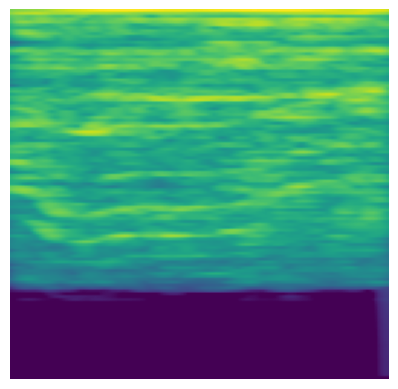

(128, 131)


In [72]:
showimg(spec_to_image(get_melspectrogram_db(str(caterwaul_path[4]))))

In [80]:
from PIL import Image

for i in range(len(caterwaul_path)):
    im = Image.fromarray(spec_to_image(get_melspectrogram_db(str(caterwaul_path[i]))))
    im.save("/catclass_ai/img_data/train/caterwaul/"+str(caterwaul_path[i]).split("/")[-1].split(".")[0]+'.jpeg')

In [81]:
from PIL import Image

for i in range(len(meow_path)):
    im = Image.fromarray(spec_to_image(get_melspectrogram_db(str(meow_path[i]))))
    im.save("/catclass_ai/img_data/train/meow/"+str(meow_path[i]).split("/")[-1].split(".")[0]+'.jpeg')

In [84]:
from PIL import Image

for i in range(len(caterwaul_val_path)):
    im = Image.fromarray(spec_to_image(get_melspectrogram_db(str(caterwaul_val_path[i]))))
    im.save("/catclass_ai/img_data/val/caterwaul/"+str(caterwaul_val_path[i]).split("/")[-1].split(".")[0]+'.jpeg')

In [85]:
from PIL import Image

for i in range(len(meow_val_path)):
    im = Image.fromarray(spec_to_image(get_melspectrogram_db(str(meow_val_path[i]))))
    im.save("/catclass_ai/img_data/val/meow/"+str(meow_val_path[i]).split("/")[-1].split(".")[0]+'.jpeg')

In [4]:
from keras.preprocessing.image import ImageDataGenerator

In [5]:
train = ImageDataGenerator(rescale=1/255)
train_dataset = train.flow_from_directory("/catclass_ai/img_data/train/",
                                          target_size=(128,131),
                                          batch_size = 32,
                                          class_mode = 'binary')

Found 22695 images belonging to 2 classes.


In [6]:
# 테스트 데이터 생성하기
test = ImageDataGenerator(rescale=1/255)

test_dataset = test.flow_from_directory("/catclass_ai/img_data/val/",
                                          target_size=(128,131),
                                          batch_size =32,
                                          class_mode = 'binary')

Found 333 images belonging to 2 classes.


In [7]:
train_dataset.class_indices

{'caterwaul': 0, 'meow': 1}

1.0


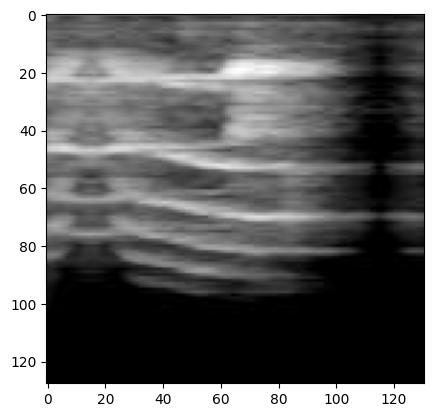

1.0


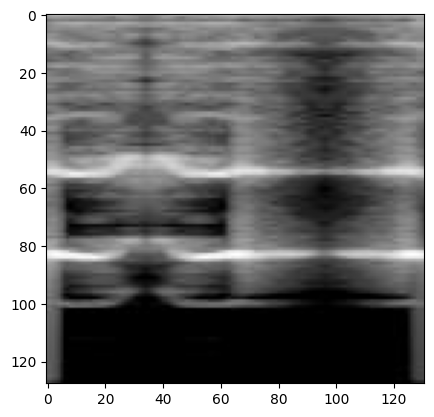

1.0


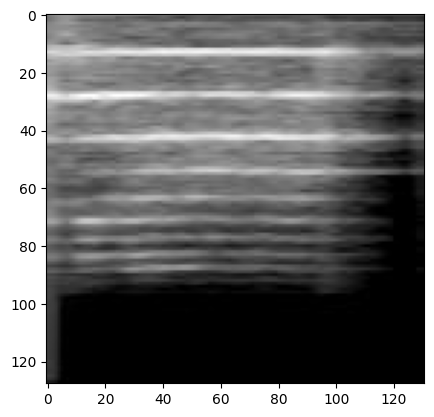

1.0


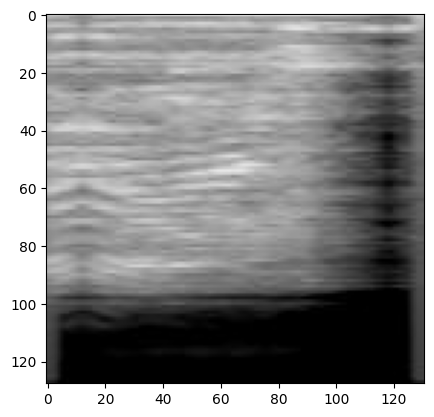

0.0


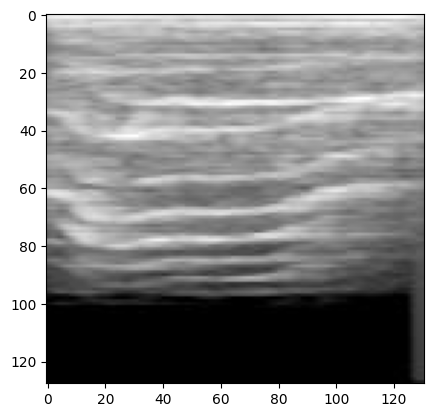

In [8]:
# 학습 데이터 레이블과 이미지 확인하기
for _ in range(5):
    img, label = train_dataset.next()
    print(label[0])
    plt.imshow(img[0])
    plt.show()

In [22]:
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import Dropout, Conv2D, MaxPool2D, Flatten, Dense
import random

In [23]:
model = Sequential()
model.add(Conv2D(64,(3,3),activation='relu',input_shape=(128,131,3)))
model.add(MaxPool2D((2,2)))
model.add(Dropout(0.5))
model.add(Conv2D(64,(3,3),activation='relu',input_shape=(128,131,3)))
model.add(MaxPool2D((2,2)))
model.add(Dropout(0.5))
model.add(Conv2D(64,(3,3),activation='relu',input_shape=(128,131,3)))
model.add(MaxPool2D((2,2)))
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(128,activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(1, activation="sigmoid"))

In [24]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 126, 129, 64)      1792      
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 63, 64, 64)        0         
 g2D)                                                            
                                                                 
 dropout_8 (Dropout)         (None, 63, 64, 64)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 61, 62, 64)        36928     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 30, 31, 64)        0         
 g2D)                                                            
                                                                 
 dropout_9 (Dropout)         (None, 30, 31, 64)       

In [25]:
model.compile(optimizer = "adam" ,
              loss = "binary_crossentropy",
              metrics=["accuracy"])

In [26]:
from keras.callbacks import EarlyStopping

custom_early_stopping = EarlyStopping(
    monitor='accuracy',
    patience=15
)

In [27]:
# 모델 학습

from keras.callbacks import ModelCheckpoint

# ModelCheckpoint 객체를 생성합니다.
checkpoint = ModelCheckpoint("/catclass_ai/weights.h5", monitor='val_loss', verbose=1, save_best_only=True, mode='max', save_weights_only=True)

# 모델을 학습합니다. ModelCheckpoint 객체를 콜백으로 전달합니다.

history =  model.fit(train_dataset,
                     epochs=100,
                     batch_size=32,
                     verbose=1,
                     validation_data = test_dataset,
                     callbacks=[custom_early_stopping,checkpoint])

Epoch 1/100
710/710 [==============================] - ETA: 0s - loss: 0.1746 - accuracy: 0.9337
Epoch 1: val_accuracy improved from -inf to 0.98498, saving model to /catclass_ai/weights.h5
710/710 [==============================] - 17s 22ms/step - loss: 0.1746 - accuracy: 0.9337 - val_loss: 0.0796 - val_accuracy: 0.9850
Epoch 2/100
709/710 [============================>.] - ETA: 0s - loss: 0.0754 - accuracy: 0.9808
Epoch 2: val_accuracy did not improve from 0.98498
710/710 [==============================] - 16s 22ms/step - loss: 0.0753 - accuracy: 0.9809 - val_loss: 0.0918 - val_accuracy: 0.9820
Epoch 3/100
709/710 [============================>.] - ETA: 0s - loss: 0.0704 - accuracy: 0.9812
Epoch 3: val_accuracy did not improve from 0.98498
710/710 [==============================] - 15s 22ms/step - loss: 0.0705 - accuracy: 0.9812 - val_loss: 0.0641 - val_accuracy: 0.9820
Epoch 4/100
710/710 [==============================] - ETA: 0s - loss: 0.0663 - accuracy: 0.9817
Epoch 4: val_accur

KeyboardInterrupt: 

In [34]:
# model.evaluate로 평가하기
score = model.evaluate(test_dataset, verbose=1)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

11/11 [==============================] - 0s 18ms/step - loss: 0.0796 - accuracy: 0.9850
Test loss: 0.07956543564796448
Test accuracy: 0.9849849939346313


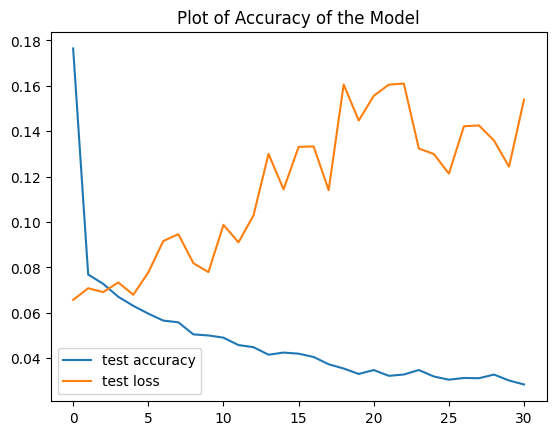

In [35]:
plt.title('Plot of Accuracy of the Model')
plt.plot(history.history['loss'], label='test accuracy')
plt.plot(history.history['val_loss'], label='test loss')
plt.legend()
plt.show()

In [32]:
model.load_weights("/catclass_ai/weights.h5")

In [33]:
model.save('/catclass_ai/model.h5')

/root/anaconda3/envs/catclass/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [45]:
from glob import glob
# glob: 사용자가 제시한 조건에 맞는 파일명을 리스트 형식으로 반환
base_dir = '/catclass_ai/augmented_data/test/meow'
train_folder = glob(base_dir)
train_path = []
for folder in train_folder:
    tmp = glob(folder + '/*')
    train_path += tmp
test_meow_path = train_path

In [46]:
print(test_meow_path)

['/catclass_ai/augmented_data/test/meow/K4tAuzHXCVw_10_27.wav', '/catclass_ai/augmented_data/test/meow/M7jtDlV39r8_30_92.wav', '/catclass_ai/augmented_data/test/meow/8EmUkaIhr8M_30_269.wav', '/catclass_ai/augmented_data/test/meow/N25QXGVVXog_30_48.wav', '/catclass_ai/augmented_data/test/meow/IyBazGaHPeo_30_199.wav', '/catclass_ai/augmented_data/test/meow/3-Q-3tZRaLI_30_53.wav', '/catclass_ai/augmented_data/test/meow/6zwSfh9rFM8_30_2.wav', '/catclass_ai/augmented_data/test/meow/51I8U2iWrpM_30_55.wav', '/catclass_ai/augmented_data/test/meow/-4o0jRbgHr4_30_110.wav', '/catclass_ai/augmented_data/test/meow/5bf0JVLSIbY_30_83.wav', '/catclass_ai/augmented_data/test/meow/-_8E5aDUqas_30_19.wav', '/catclass_ai/augmented_data/test/meow/5-VdQ476qJ8_30_53.wav', '/catclass_ai/augmented_data/test/meow/BO7DUflFfIc_30_70.wav', '/catclass_ai/augmented_data/test/meow/-ugtQOTQMxM_30_49.wav', '/catclass_ai/augmented_data/test/meow/C0AY0FEhOxU_30_621.wav', '/catclass_ai/augmented_data/test/meow/1yADGwQBDrE_

In [47]:
from glob import glob
# glob: 사용자가 제시한 조건에 맞는 파일명을 리스트 형식으로 반환
base_dir = '/catclass_ai/augmented_data/test/caterwaul'
train_folder = glob(base_dir)
train_path = []
for folder in train_folder:
    tmp = glob(folder + '/*')
    train_path += tmp
test_caterwaul_path = train_path

In [52]:
spec_to_image(get_melspectrogram_db(str(test_meow_path[0]))).shape

(128, 131)

In [56]:
from PIL import Image
def model_test(filename):
    im = Image.fromarray(spec_to_image(get_melspectrogram_db(filename)))
    im.save("/catclass_ai/0.jpeg")
    img1 = load_img("/catclass_ai/0.jpeg",target_size=(128,131))
    plt.imshow(img1)
    imarr = img_to_array(img1)
    X = np.expand_dims(imarr,axis=0)
    val = model.predict(X)
    print(val)
    if val == 1:
        plt.xlabel("Meow",fontsize=30)
    elif val == 0:
        plt.xlabel("Caterwaul",fontsize=30)

1/1 [==============================] - 0s 25ms/step
[[0.]]


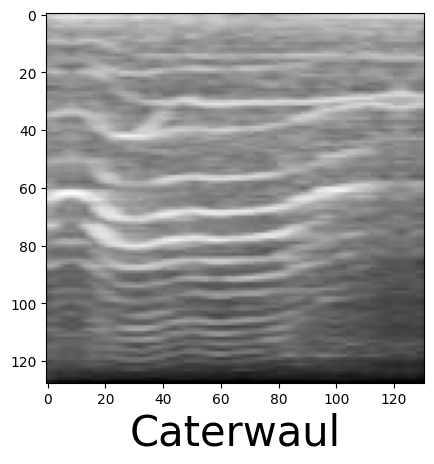

In [76]:
model_test(str(test_caterwaul_path[15]))